In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# 필요한 모듈 임포트
from dataload.load_multimodal_data import load_multimodal_data
from model.multimodal_portfolio import MultimodalPortfolio
from model.sam import SAM
from model.loss import max_sharpe, equal_risk_parity

# 데이터 로드
aligned_train, aligned_test, times_te, config = load_multimodal_data()
print(f"훈련 데이터 크기: {len(aligned_train)}")
print(f"테스트 데이터 크기: {len(aligned_test)}")

# 데이터셋 및 데이터로더 정의
class MultimodalDataset(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        num_data, img_data = self.data[idx]
        return torch.FloatTensor(num_data), torch.FloatTensor(img_data)

train_dataset = MultimodalDataset(aligned_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = MultimodalDataset(aligned_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

n_layers = 2
hidden_dim = 64
n_stocks = config['N_STOCK']
cnn_output_dim = 50

model = MultimodalPortfolio(n_layers, hidden_dim, n_stocks, cnn_output_dim)
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')

훈련 데이터 크기: 3740
테스트 데이터 크기: 1194


In [2]:
# 모델 파라미터 확인
for name, param in model.named_parameters():
    print(f"{name}: requires_grad = {param.requires_grad}, shape = {param.shape}")

cnn.conv1.weight: requires_grad = True, shape = torch.Size([32, 1, 3, 3])
cnn.conv1.bias: requires_grad = True, shape = torch.Size([32])
cnn.conv2.weight: requires_grad = True, shape = torch.Size([64, 32, 3, 3])
cnn.conv2.bias: requires_grad = True, shape = torch.Size([64])
cnn.fc1.weight: requires_grad = True, shape = torch.Size([128, 29696])
cnn.fc1.bias: requires_grad = True, shape = torch.Size([128])
cnn.fc2.weight: requires_grad = True, shape = torch.Size([50, 128])
cnn.fc2.bias: requires_grad = True, shape = torch.Size([50])
gru_multimodal.gru.weight_ih_l0: requires_grad = True, shape = torch.Size([192, 2550])
gru_multimodal.gru.weight_hh_l0: requires_grad = True, shape = torch.Size([192, 64])
gru_multimodal.gru.bias_ih_l0: requires_grad = True, shape = torch.Size([192])
gru_multimodal.gru.bias_hh_l0: requires_grad = True, shape = torch.Size([192])
gru_multimodal.gru.weight_ih_l1: requires_grad = True, shape = torch.Size([192, 64])
gru_multimodal.gru.weight_hh_l1: requires_grad =

In [3]:
# 손실 함수 및 옵티마이저 정의
criterion = max_sharpe  # 또는 equal_risk_parity
base_optimizer = optim.Adam
optimizer = SAM(model.parameters(), base_optimizer, lr=0.001)

In [4]:
print(f"Numerical data shape: {aligned_train[0][0].shape}")
print(f"Image data shape: {aligned_train[0][1].shape}")

Numerical data shape: (60, 50)
Image data shape: (50, 64, 117)


In [5]:
# from torchsummary import summary
# # 모델 요약 출력
# summary(model, [(60, 50), (50, 64, 117)], batch_size=32, device='cuda')

In [6]:
# 모델 요약 출력
def print_model_summary(model):
    print(model)
    print("\nModel parameters:")
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_params:,}")
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Trainable parameters: {trainable_params:,}")

print_model_summary(model)

# 샘플 입력으로 모델 테스트
sample_num_data = torch.randn(1, 60, 50).to(model.device)
sample_img_data = torch.randn(1, 50, 64, 117).to(model.device)
sample_output = model(sample_num_data, sample_img_data)
print(f"\nSample output shape: {sample_output.shape}")

MultimodalPortfolio(
  (cnn): CNN(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc1): Linear(in_features=29696, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=50, bias=True)
  )
  (gru_multimodal): GRUMultimodal(
    (gru): GRU(2550, 64, num_layers=2, batch_first=True)
    (dropout): Dropout(p=0.3, inplace=False)
    (fc): Linear(in_features=64, out_features=50, bias=True)
    (swish): SiLU()
  )
)

Model parameters:
Total parameters: 4,356,964
Trainable parameters: 4,356,964

Sample output shape: torch.Size([1, 50])


In [7]:
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0
    for num_data, img_data in loader:
        num_data = num_data.to(model.device)
        img_data = img_data.to(model.device)
        
        # 첫 번째 forward pass
        output = model(num_data, img_data)
        loss = criterion(num_data, output)
        
        # 첫 번째 backward pass
        loss.backward()
        optimizer.first_step(zero_grad=True)
        
        # 두 번째 forward-backward pass
        output = model(num_data, img_data)
        criterion(num_data, output).backward()
        optimizer.second_step(zero_grad=True)
        
        total_loss += loss.item()
    
    return total_loss / len(loader)

In [8]:
def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for num_data, img_data in loader:
            num_data = num_data.to(model.device)
            img_data = img_data.to(model.device)
            
            print(f"Num data shape: {num_data.shape}")
            print(f"Img data shape: {img_data.shape}")
            output = model(num_data, img_data)
            print(f"Output shape: {output.shape}")
            loss = criterion(num_data, output)  # 순서 변경
            
            total_loss += loss.item()
    
    return total_loss / len(loader)

In [ ]:
# 학습 실행
n_epochs = 10
train_losses = []
val_losses = []

for epoch in range(n_epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer)
    val_loss = evaluate(model, test_loader, criterion)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

In [1]:
# 학습 결과 시각화
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

NameError: name 'plt' is not defined

1. MultimodalPortfolio input shapes: x_num=torch.Size([32, 60, 50]), x_img=torch.Size([32, 50, 64, 117])
4. CNN input shape: torch.Size([1600, 1, 64, 117])
5. After first conv and pool: torch.Size([1600, 32, 32, 58])
6. After second conv and pool: torch.Size([1600, 64, 16, 29])
7. After flatten: torch.Size([1600, 29696])
8. CNN output shape: torch.Size([1600, 50])
2. CNN output shape: torch.Size([32, 50, 50])
Adjusted CNN output shape: torch.Size([32, 60, 2500])
3. Combined input shape: torch.Size([32, 60, 2550])
GRUMultimodal input shape: torch.Size([32, 60, 2550])
After GRU shape: torch.Size([32, 60, 64])
h_t shape: torch.Size([32, 64])
After FC shape: torch.Size([32, 50])
Final output shape: torch.Size([32, 50])


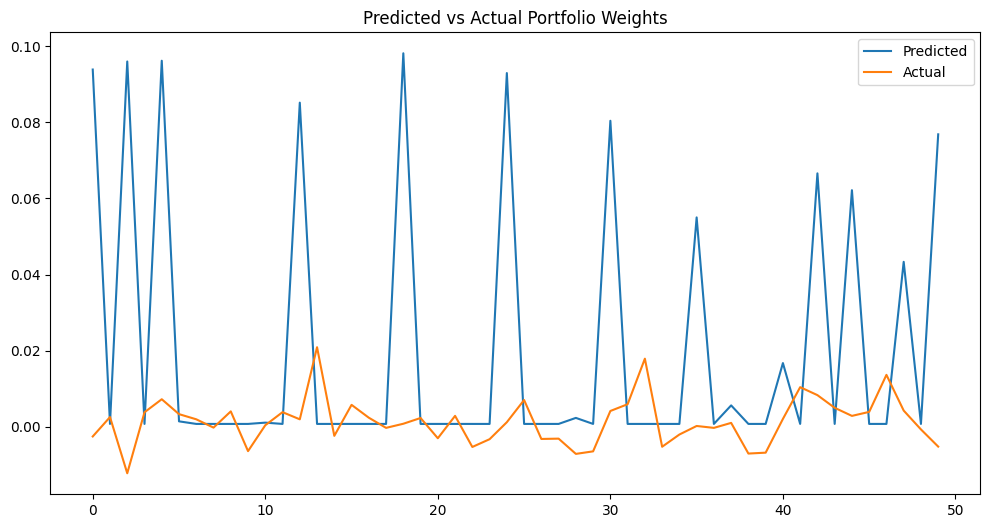

In [17]:
# 모델 예측 결과 시각화 (예시)
model.eval()
with torch.no_grad():
    num_data, img_data = next(iter(test_loader))
    num_data = num_data.to(model.device)
    img_data = img_data.to(model.device)
    
    output = model(num_data, img_data)
    
plt.figure(figsize=(12, 6))
plt.plot(output[1].cpu().numpy(), label='Predicted')
plt.plot(num_data[1, -1].cpu().numpy(), label='Actual')
plt.legend()
plt.title('Predicted vs Actual Portfolio Weights')
plt.show()

In [15]:
next(iter(test_loader))

[tensor([[[-4.1840e-03, -9.2210e-03,  1.8132e-02,  ..., -7.8434e-03,
           -2.3677e-03, -1.2056e-03],
          [-1.7625e-03,  1.4367e-03,  4.2924e-03,  ...,  1.8848e-03,
            2.8930e-03, -3.1065e-03],
          [ 4.0242e-03, -1.3566e-03, -4.5505e-03,  ..., -1.7675e-02,
           -7.4439e-04,  1.2955e-03],
          ...,
          [ 2.7817e-04, -4.7181e-03,  5.5904e-03,  ..., -3.3138e-03,
           -8.4233e-03,  8.5577e-04],
          [ 7.4190e-03,  2.7426e-03,  1.7038e-02,  ...,  1.3093e-03,
            2.1592e-03, -2.0554e-03],
          [-5.1945e-03, -2.5898e-03,  2.6981e-03,  ..., -7.0034e-03,
            1.0311e-03, -1.7161e-03]],
 
         [[-1.7625e-03,  1.4367e-03,  4.2924e-03,  ...,  1.8848e-03,
            2.8930e-03, -3.1065e-03],
          [ 4.0242e-03, -1.3566e-03, -4.5505e-03,  ..., -1.7675e-02,
           -7.4439e-04,  1.2955e-03],
          [ 4.0081e-03, -1.3585e-03, -4.5713e-03,  ..., -1.7993e-02,
           -7.4495e-04,  1.2939e-03],
          ...,
    